# KNN Models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd

import torch
import pytorch_common.util as pu

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl

ModuleNotFoundError: No module named 'model.module.categorial_features_linear'

<Figure size 432x288 with 0 Axes>

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [6]:
pu.set_device_name('gpu')
cpu = torch.device("cpu")

In [7]:
pu.get_device()

device(type='cuda', index=0)

In [8]:
torch.cuda.is_available()

True

In [9]:
torch.__version__

'1.11.0'

## Carga de dataset

1. importamos los archivos de peliculas y ratings preprocesados prebiamente en mongodb:

In [10]:
def features_fn(obs, device): return torch.tensor(obs[['user_seq', 'movie_seq']].values).to(device)
def target_fn(obs, device):   return torch.tensor(obs['user_movie_rating'].values).to(device)

In [11]:
dataset = ds.MovieLensTMDbJSONDataset(transform=features_fn, target_transform=target_fn, device=cpu)

In [12]:
user_predictor = ml.KNNUserBasedPredictor.from_data_frame(
    data          = dataset.data,
    user_seq_col  = 'user_seq',
    movie_seq_col = 'movie_seq',
    rating_col    = 'user_movie_rating',
    distance      = ml.CosineDistance()
)
# user_predictor.plot()

Building Ratting Matrix:   0%|          | 0/199791 [00:00<?, ?it/s]

Building Distances Matrix:   0%|          | 0/13280 [00:00<?, ?it/s]

In [23]:
item_predictor = ml.KNNItemBasedPredictor.from_data_frame(
    data          = dataset.data,
    user_seq_col  = 'user_seq',
    movie_seq_col = 'movie_seq',
    rating_col    = 'user_movie_rating',
    distance      = ml.CosineDistance()
)
# item_predictor.plot()

Building Ratting Matrix:   0%|          | 0/199791 [00:00<?, ?it/s]

Building Distances Matrix:   0%|          | 0/22081 [00:00<?, ?it/s]

In [24]:
ratings = np.unique(dataset.data.user_movie_rating.values)
ratings

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [25]:
validator = ml.Validator(
    n_samples  = 50,
    batch_size = 20,
    metrics    = [
        mt.RMSE(),
        mt.FBetaScore(
            beta=1,
            discretizer=dr.round_sequence(ratings), 
            num_classes=len(ratings)
        )
    ],
    predictors = [user_predictor, item_predictor]
)

summary = validator.validate(
    dataset,
    n_neighbors=5000
)

summary.save('../metrics/baseline')

Processing:   0%|          | 0/50 [00:00<?, ?it/s]

<Figure size 1440x360 with 2 Axes>

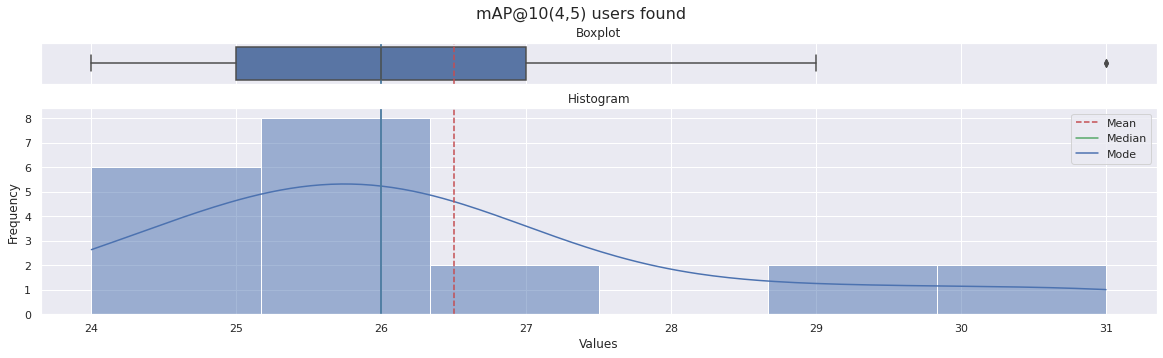

In [35]:
pl.describe_num_var(summary.data, 'mAP@10(4,5) users found')

<Figure size 1440x360 with 2 Axes>

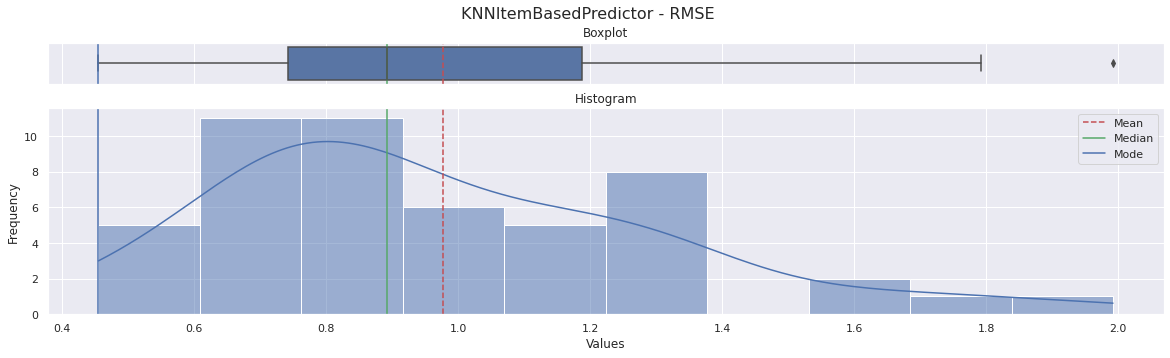

<Figure size 1440x360 with 2 Axes>

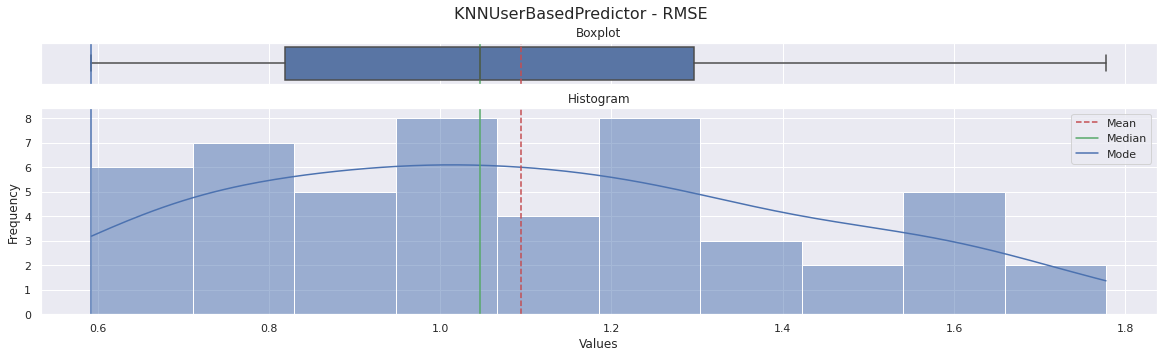

<Figure size 1440x360 with 2 Axes>

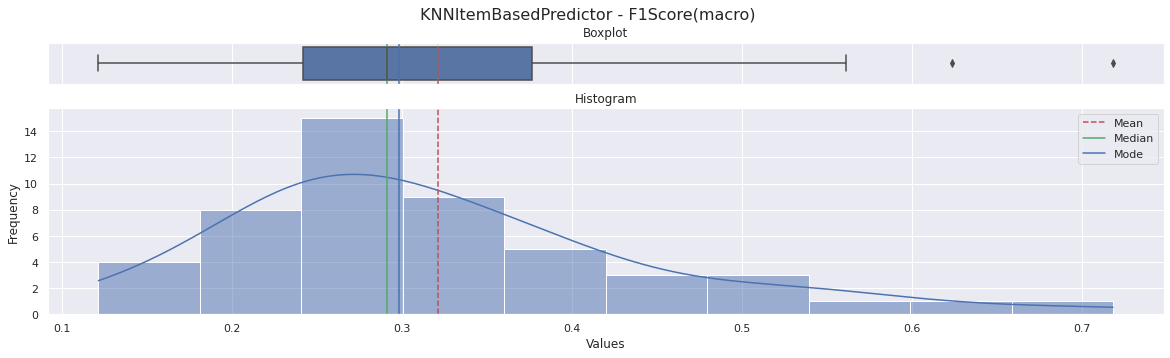

<Figure size 1440x360 with 2 Axes>

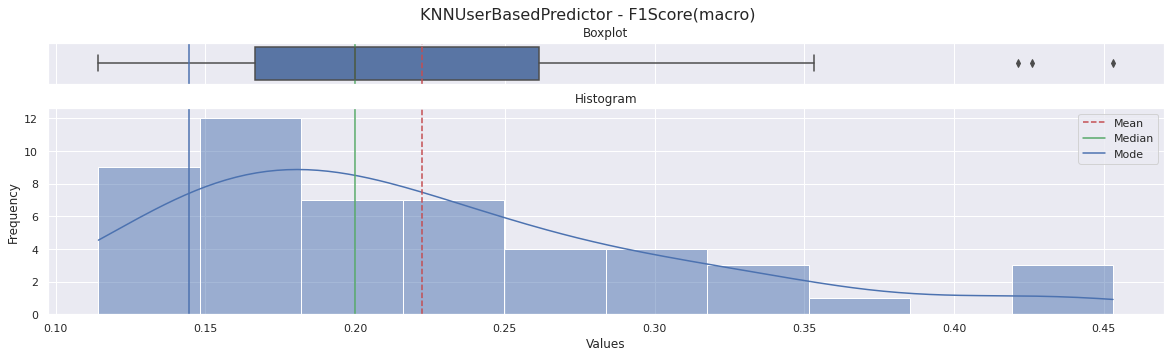

In [26]:
summary = ml.ValidatorSummary.load('../metrics/baseline')
summary.plot()

In [27]:
validator = ml.Validator(
    n_samples  = 10,
    batch_size = 3000,
    metrics    = [
        mt.MeanAveragePrecisionAtk(user_index=0, k=5, discretizer=dr.between(4, 5)),
        mt.MeanAveragePrecisionAtk(user_index=0, k=10, discretizer=dr.between(4, 5)),
        mt.MeanAveragePrecisionAtk(user_index=0, k=10, discretizer=dr.between(4, 5))
    ],
    predictors = [user_predictor, item_predictor]
)

summary = validator.validate(
    dataset, 
    n_neighbors=1000
)

summary.save('../metrics/recommendation')

Processing:   0%|          | 0/10 [00:00<?, ?it/s]

<Figure size 1440x360 with 2 Axes>

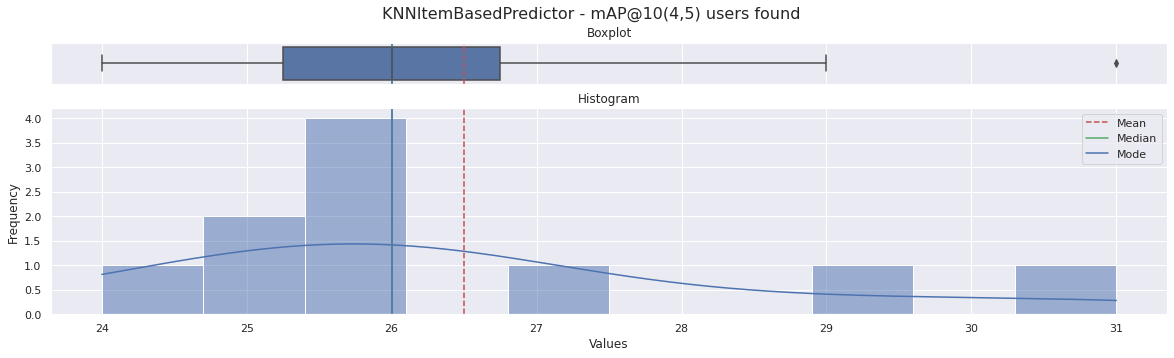

<Figure size 1440x360 with 2 Axes>

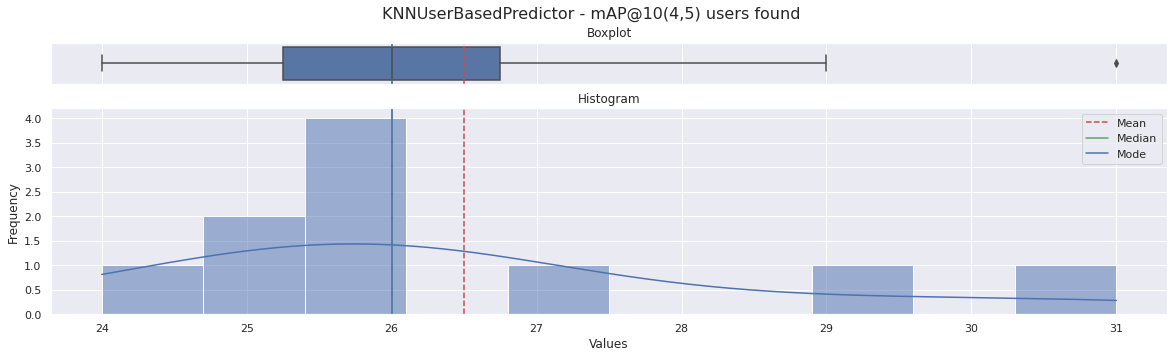

<Figure size 1440x360 with 2 Axes>

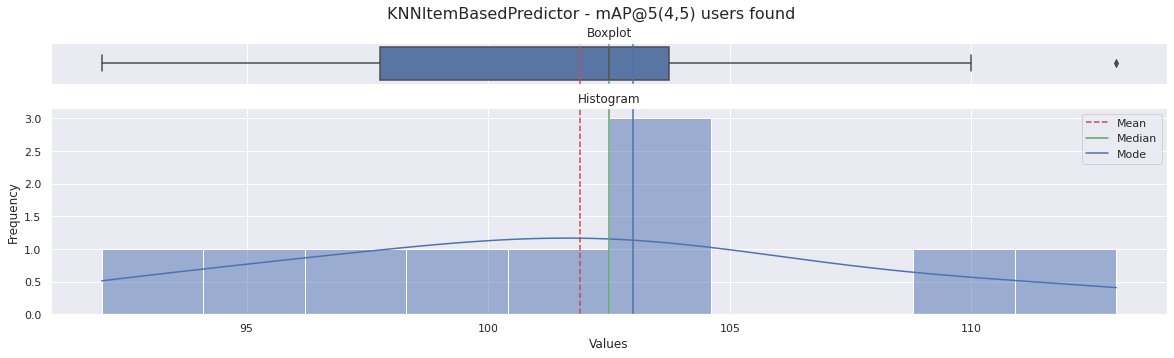

<Figure size 1440x360 with 2 Axes>

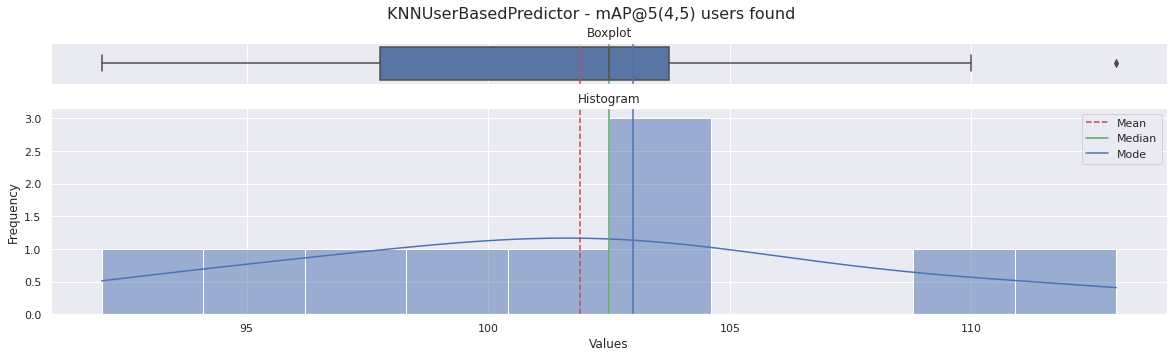

<Figure size 1440x360 with 2 Axes>

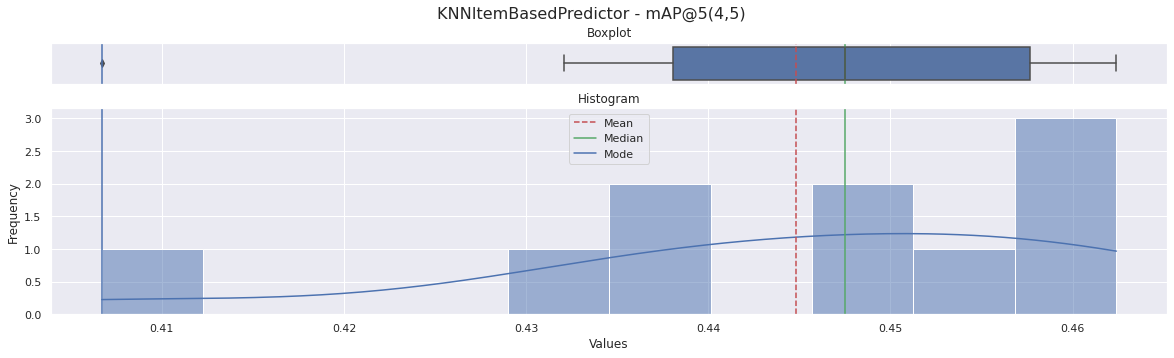

<Figure size 1440x360 with 2 Axes>

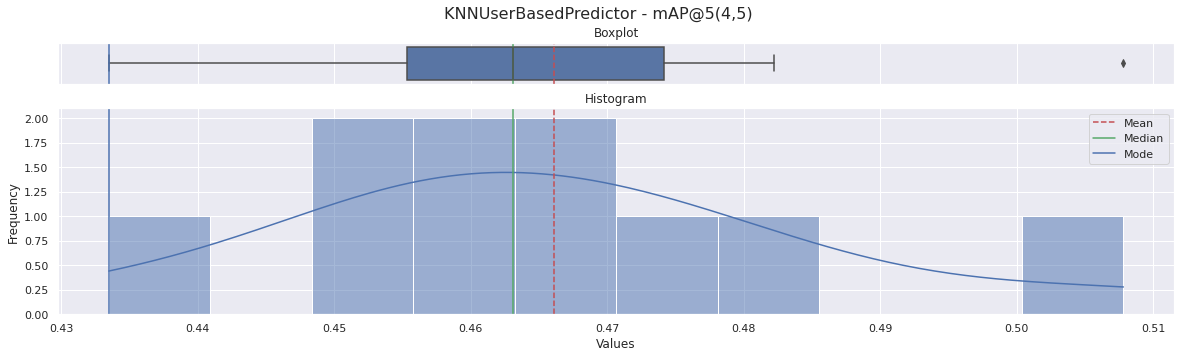

<Figure size 1440x360 with 2 Axes>

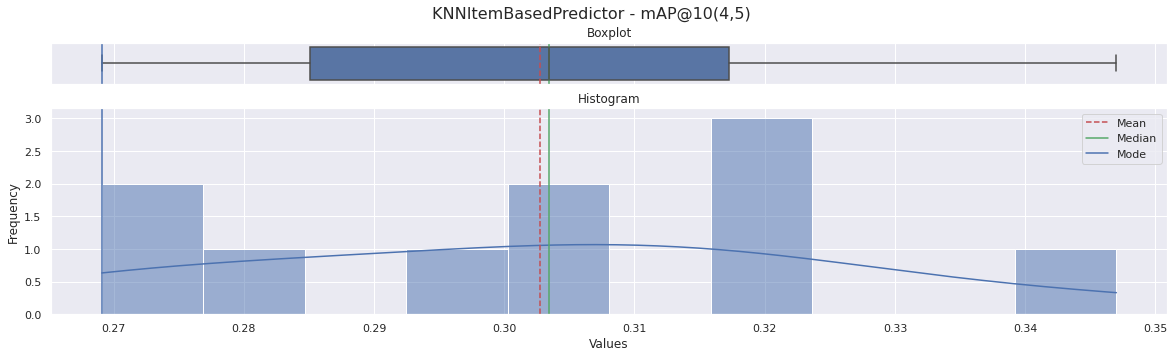

<Figure size 1440x360 with 2 Axes>

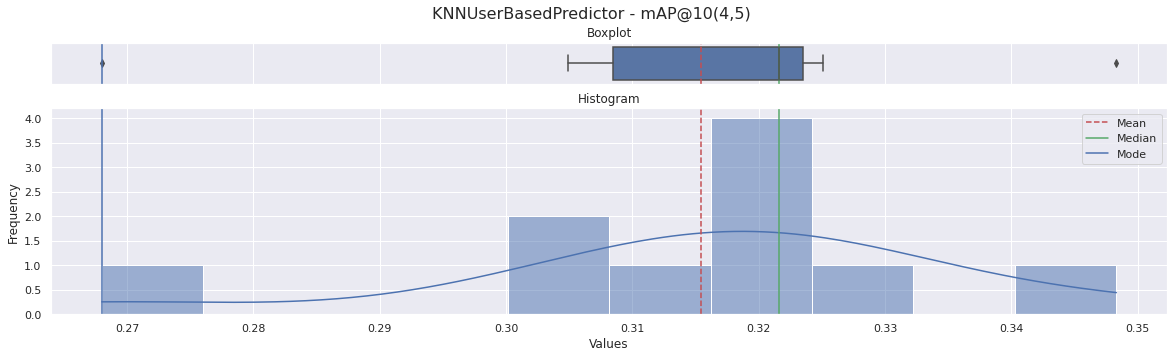

In [28]:
summary = ml.ValidatorSummary.load('../metrics/recommendation')
summary.plot()